In [1]:
import numpy as np
import torch


## Model selection strategy: 
Use 10-fold cross validation for hyperparameter selection on the training set.

In [2]:
def load_data():
    trset = np.load("data/train.npy")
    testset = np.load("data/test.npy")
    return trset, testset

In [3]:
def get_tr_and_val(trset, n_split=10):
    from sklearn.model_selection import KFold
    kf = KFold(n_split)
    splits = kf.split(trset)
    return [ (trset[s[0]], trset[s[1]]) for s in splits]

In [4]:
def get_dataloader(trset, batch_size=64, shuffle=True, split_first=False,
                                       dtype=torch.float, label_dtype=torch.long, 
                                      device=torch.device("cpu")):
    """ given a numpy array, return a DataLoader with spec'd batch size"""
    
    trset = torch.tensor(trset).to(device=device, dtype=dtype)
    from torch.utils.data import TensorDataset, DataLoader
    if split_first:
        x, y = trset[:, 1:], trset[:, 0]
        y = y.to(label_dtype)
        ds = TensorDataset(x,y)
    else:
        ds = TensorDataset(trset)
    
    return DataLoader(ds, batch_size=batch_size, shuffle=shuffle)

In [45]:
def fit_model(model, optimizer, loss_function, accuracy_function,
                  train_dl,  epochs, val_dl = None,
                  early_stopping=True,
                  stop_with='acc',
                 no_improvement_epochs=5, verbose=False):
    """Fit model to training set.
        Returns: final loss function on train and val sets.
        Early stopping based on val loss.
        no_improvement_epochs: number of epochs of no improvement in the val loss which will trigger 
        early stopping. If -1, no early stopping. """
    
    if stop_with not in ['acc', 'loss']:
        raise ValueError
    if no_improvement_epochs < 1:
        raise ValueError
    if early_stopping and val_dl is not None:
        raise ValueError
    
    def compute_loss(xb, yb):
        out = model(xb)
        return loss_function(out, yb)
    
    def compute_acc(xb,yb):
        out = model(xb)
        return accuracy_function(out, yb)
    
    def mean_stat(dl, which='loss'):
        metric = compute_loss if which=='loss' else compute_acc
        return (sum(metric(xb,yb) for xb, yb in dl) / len(dl)).item()
        
    #track losses at each epoch
    val_losses = []
    val_accuracy = []
    tr_losses = []
    tr_accuracy = []
    
    
    for epoch in range(epochs):
        
        model.train()
        for xb, yb in train_dl:
            
            #loss between model prediction and correct labels
            loss = compute_loss(xb,yb)
            #backprop into the model
            model.zero_grad()
            loss.backward()
            #update params
            optimizer.step()
        
        
        model.eval()
        with torch.no_grad():
            #at each epoch, check losses and accuracy
            tr_loss = mean_stat(train_dl, which='loss')
            tr_acc = mean_stat(train_dl, which='acc')
            tr_losses.append(tr_loss)
            tr_accuracy.append(tr_acc)
            
            if val_dl is not None:
                val_loss = mean_stat(val_dl, which='loss')
                val_acc = mean_stat(val_dl, which='acc')
                val_losses.append(val_loss)
                val_accuracy.append(val_acc)

            if verbose:
                print("Finished epoch %d"% epoch)
                print("tr loss=", tr_loss)
                print("tr acc=", tr_acc)
                if val_dl is not None:
                    print("val loss=", val_loss)
                    print("val acc=", val_acc)

        #check if early stopping is desirable
        if early_stopping and (epoch >= no_improvement_epochs):
            stop_metric = val_losses if stop_with == 'loss' else val_accuracy
            recent_val = stop_metric[-(no_improvement_epochs+1):]
            sgn = 1 if stop_with =='loss' else -1
            if ((sgn*np.diff(recent_val))>=0).all():
                print("No improvement in val for %d epochs, halting" % no_improvement_epochs)
                break
    return tr_losses, tr_accuracy, val_losses, val_accuracy
            
        
        

In [21]:
def do_cross_val(tr_set_numpy, val_function, 
                         tr_bs = 64,
                         val_bs = 128,n_split=10, n_train=None,
                 device=torch.device("cpu")):
    """ Average cost when training a particular model, with a particular set of 
    hyperparams, on different train/ val splits
        dl: dataloader containing all training data. 
        n_split: number of folds to use to split up the dataset
        n_train: how many of these to train on and subsequently average over
        
        trset: numpy array holding mnist training data"""
    if n_train is None:
        n_train = n_split
    if n_train > n_split:
        raise ValueError
    
    tr_and_val_splits = get_tr_and_val(tr_set_numpy, n_split=n_split)

    costs = []
    for ii in range(n_train):
        t,v = tr_and_val_splits[ii]
        train_dl = get_dataloader(t, batch_size=tr_bs,
                                  shuffle=True,split_first=True,label_dtype=torch.long, 
                                     device=device)
        val_dl = get_dataloader(t, batch_size=val_bs,
                                  shuffle=True,split_first=True,label_dtype=torch.long, 
                                     device=device)
        
        cost = val_function(train_dl, val_dl)
#         print("Metric on %dth fold:"%ii, cost)
        costs.append(cost)
    return np.mean(costs)
    

In [7]:
from torch import nn

In [8]:
class Lambda(nn.Module):
    """a lambda-layer"""
    def __init__(self, func):
        super().__init__()
        self.func = func
    
    def forward(self, x):
        return self.func(x)    

    

In [9]:
def preprocess(x):
    """Preprocess mnist data in a format amenable to conv layers"""
    # reshape to 2d and add a (dummy) channel
    x = x.view(-1,1, 28,28)
    # cast to torch.float32, default for conv layers
    return x.to(torch.float)
    

## Conv model for digit recognition
Inputs are (N, 784) real tensors.
First, they're reshaped to 2d images with 1 channel. Then conv+relu, maxpool, conv+relu, global average pooling, and a final linear layer to produce the logits

In [10]:
def get_convmodel():
    return nn.Sequential( Lambda(preprocess), 
                            nn.Conv2d(1,32,3,padding=1), 
                             nn.ReLU(),
                             nn.MaxPool2d(2),
                            nn.Conv2d(32, 32,3,padding=1),
                           nn.ReLU(),
                            nn.AvgPool2d(14), 
                            Lambda(torch.squeeze),
                            nn.Linear(32,10)
                         )
                            

In [11]:
def loss_fn(logits, labels):
    """ The cross-entropy loss between model's logits and integer 
    labels 0....9.
        logits = (N, 10) tensor of logit values. The model probs for each class are defined as the softmax
        of the logits.
        labels = (N,) tensor of integer labels.
        
        returns: scalar loss tensor"""

    return nn.functional.cross_entropy(logits, labels)

def acc_fn(logits, labels):
    """Accuracy of model predictions (defined as most likely values)"""
    max_logits, indices = torch.max(logits, 1)
    return (labels.to(indices.dtype)==indices).to(torch.float).mean()

In [12]:
dev="cuda:0"
device = torch.device(dev) if torch.cuda.is_available() else "cpu"
print(device)

cuda:0


train_dl = get_dataloader(tv[0][0], batch_size=64, shuffle=True, split_first=True, label_dtype=torch.long, 
                                     device=dev)
val_dl = get_dataloader(tv[0][1], batch_size=256, shuffle=False, split_first=True, label_dtype=torch.long,
                                       device=dev)

def val_function(train_dl, val_dl):
    """Defines a metric for training quality based on val performance"""
    convmodel = get_convmodel()
    convmodel.to(device)
    optimizer = torch.optim.Adam(convmodel.parameters(),lr=lr)
    tr_loss, tr_acc, val_loss, val_acc = fit_model(convmodel, optimizer, loss_fn, acc_fn,
                                                    train_dl, val_dl, epochs,
                                                  early_stopping=True,
                                                  stop_with='acc',
                                                    no_improvement_epochs=5)    
    del convmodel
    del optimizer
    
    return val_acc[-1]

In [13]:
def make_val_function(model, optimizer, epochs, 
                         early_stopping=True, stop_with = 'acc', 
                         no_improvement_epochs=5):
    def val_function(train_dl, val_dl):
    
        tr_loss, tr_acc, val_loss, val_acc = fit_model(model, optimizer, loss_fn, acc_fn,
                                                        train_dl, val_dl, epochs,
                                                          early_stopping=early_stopping,
                                                          stop_with=stop_with,
                                                            no_improvement_epochs=no_improvement_epochs)    
        
        return val_acc[-1]
    return val_function
    

In [23]:
def run_cv(modelgen, tr_numpy, hyperparams, epochs,
                       n_split=10, n_train=None,device=torch.device("cpu"),
                          early_stopping=True, stop_with='acc',
                          no_improvement_epochs=5):
    nh = len(hyperparams['lr'])
    scores = []
    for ii in range(nh):
        lr = hyperparams['lr'][ii]
        batch_size = hyperparams['batch_size'][ii]
        weight_decay = hyperparams['weight_decay'][ii]
        model = modelgen().to(device)
        optimizer = torch.optim.Adam(model.parameters(),lr=lr, weight_decay=weight_decay)
        
        val_fn = make_val_function(model, optimizer, epochs, early_stopping=early_stopping,
                                            stop_with=stop_with,no_improvement_epochs=no_improvement_epochs)
        score=do_cross_val(tr_numpy, val_fn, 
                         tr_bs=batch_size,
                         val_bs=batch_size,n_split=n_split, n_train=n_train,
                 device=device)
        scores.append(score)
    
        print("score = ", score)
        del model
        del optimizer
    return scores   

In [24]:
tr, test = load_data()

In [31]:
nh=20
lr = 10**np.random.uniform(-4,0,nh)
weight_decay=10**np.random.uniform(-6,-1,nh)
batch_size=[64] * nh
hyperparams = dict(lr=lr,batch_size=batch_size, weight_decay=weight_decay)
epochs=40
n_split=5
n_train=3
early_stopping=True
stop_with = 'acc'
no_improvement_epochs = 5
np.save("conv_hyperparams", hyperparams)


In [32]:
scores = run_cv(get_convmodel, tr, hyperparams, epochs,
                   n_split=n_split, 
                   n_train=n_train, device=device,early_stopping=early_stopping,
                   stop_with=stop_with, no_improvement_epochs=no_improvement_epochs)
np.save("conv_crossval_scores", scores)

score =  0.9058928489685059
score =  0.9908432563145956
score =  0.9694642623265585
score =  0.8618848919868469
No improvement in val for 5 epochs, halting
score =  0.9821924567222595
score =  0.09904761860768001
score =  0.10895833124717076
score =  0.21895832816759744
score =  0.9901686509450277
score =  0.09852182616790135
score =  0.10176587104797363
score =  0.10691468169291814
score =  0.988998015721639
score =  0.9830753803253174
score =  0.9252579212188721
score =  0.9162003993988037
score =  0.9817063411076864
score =  0.9906547466913859
No improvement in val for 5 epochs, halting
score =  0.346468244989713
score =  0.9571329355239868


In [33]:
best_indx = np.argmax(scores)

In [34]:
best_lr = lr[best_indx]
best_wd = weight_decay[best_indx]

In [42]:
scores[best_indx]

0.9908432563145956

In [35]:
print(best_lr)
print(best_wd)

0.000947071148987873
1.1619816057237527e-06


## train with CV'd params on the full tr set

In [38]:
convmodel = get_convmodel().to(device)

In [40]:
optimizer = torch.optim.Adam(convmodel.parameters(),lr=best_lr, weight_decay=best_wd)

In [50]:
train_dl = get_dataloader(tr, batch_size=batch_size[best_indx], split_first=True, shuffle=True, 
                             device=device)

In [51]:
tr_loss, tr_acc, val_loss, val_acc = fit_model(convmodel, optimizer, loss_fn, acc_fn,
                                              train_dl, epochs,
                                               val_dl=None,
                                              early_stopping=False,
                                             verbose=True)

Finished epoch 0
tr loss= 0.4830175042152405
tr acc= 0.881135880947113
Finished epoch 1
tr loss= 0.23907466232776642
tr acc= 0.9331954121589661
Finished epoch 2
tr loss= 0.1813211739063263
tr acc= 0.9483923316001892
Finished epoch 3
tr loss= 0.2035452127456665
tr acc= 0.9387842416763306
Finished epoch 4
tr loss= 0.13150101900100708
tr acc= 0.9614012837409973
Finished epoch 5
tr loss= 0.13554169237613678
tr acc= 0.9586425423622131
Finished epoch 6
tr loss= 0.1638108491897583
tr acc= 0.9497479200363159
Finished epoch 7
tr loss= 0.10807457566261292
tr acc= 0.9672755002975464
Finished epoch 8
tr loss= 0.1056978851556778
tr acc= 0.9665858149528503
Finished epoch 9
tr loss= 0.1153675839304924
tr acc= 0.9648972749710083
Finished epoch 10
tr loss= 0.11238102614879608
tr acc= 0.9665144681930542
Finished epoch 11
tr loss= 0.08094184845685959
tr acc= 0.975694477558136
Finished epoch 12
tr loss= 0.09628822654485703
tr acc= 0.9698202013969421
Finished epoch 13
tr loss= 0.08934923261404037
tr acc= 0

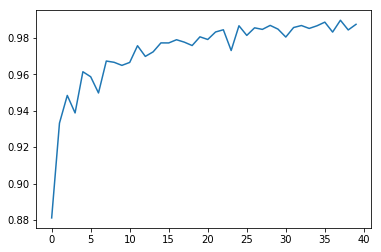

In [55]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
plt.plot(tr_acc)

In [56]:
statedict = convmodel.state_dict()

In [57]:
torch.save(statedict, "convmodel_statedict")

### Prediction on test set

In [62]:
xtst = torch.tensor(test).to(device)

In [63]:
with torch.no_grad():
    convmodel.eval()
    logits = convmodel(xtst)
    __, preds = torch.max(logits, 1)
    

In [65]:
preds = preds.cpu().numpy()

In [67]:
image_ids = np.arange(1, preds.shape[0]+1)

In [70]:
outputs = np.stack([image_ids, preds], axis=1)

In [75]:
np.savetxt("predictions.csv", outputs, delimiter=',',fmt='%d', 
          header="ImageId,Label",comments='')